# <font color ='blue'>Zillow Regression Project - Working Copy

In [1]:
# import pandas and numpy to start coding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split

# <font color = 'red'>Planning

### Project Goals

- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each county.


### Project Description

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebooks
    - Acquire and Prepare Modules
    - Misc Artifacts
1. Regression Model (Linear or Non-Linear)
2. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
3. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

### Data Dictionary (Add to README)

In [2]:
# Read Data Dictionary from working directory
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


# <font color = 'red'> Acquisition (Get and Clean Data)

## <font color = 'red'>Get Data

- Added env.py to the repo .gitignore file so env.py won't be pushed to github
- Created an env file that contains my username, password, and host address fo the MySQL Server.

In [3]:
# import env file for hostname, username, password, and db_name
from env import host, user, password, db_name

In [4]:
# Pass env file authentication to container 'url'
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

### Pull records of houses with transactions from 2017

In [5]:
# define sql search for all records from all tables
sql ='''
SELECT prop17.parcelid, prop17.calculatedfinishedsquarefeet,
prop17.yearbuilt, prop17.bedroomcnt, prop17.bathroomcnt, prop17.taxvaluedollarcnt,
prop17.fips, pred17.transactiondate, prop17.taxamount
FROM properties_2017 prop17
JOIN predictions_2017 pred17  USING (parcelid)
LEFT JOIN propertylandusetype using (propertylandusetypeid)
WHERE propertylandusetypeid='261'
'''

#### Note: Removed LIKE '2017%' since it resulted in error  for unknown support  for (''')

### Take Aways:
- Identified the following list but limited IAW project guidelines:
    - pred17.id, pred17.parcelid, pred17.transactiondate, prop17.calculatedfinishedsquarefeet, 
prop17.yearbuilt, prop17.bedroomcnt, prop17.bathroomcnt, prop17.taxvaluedollarcnt, prop17.taxamount, 
prop17.fips, prop17.regionidcounty, prop17.regionidzip, prop17.lotsizesquarefeet, prop17.poolcnt, prop17.fireplacecnt

In [6]:
# load zillow data from saved csv or pull from sql server and save to csv
import os
file = 'zillow_data.csv'
if os.path.isfile(file):
    df = pd.read_csv(file, index_col=0)
else:
    df = pd.read_sql(sql,url)
    df.to_csv(file)
df.head()

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,fips,transactiondate,taxamount
0,14297519,3100.0,1998.0,4.0,3.5,1023282.0,6059.0,2017-01-01,11013.72
1,17052889,1465.0,1967.0,2.0,1.0,464000.0,6111.0,2017-01-01,5672.48
2,14186244,1243.0,1962.0,3.0,2.0,564778.0,6059.0,2017-01-01,6488.30
3,12177905,2376.0,1970.0,4.0,3.0,145143.0,6037.0,2017-01-01,1777.51
4,12095076,2962.0,1950.0,4.0,3.0,773303.0,6037.0,2017-01-01,9516.26


### Show df info()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   calculatedfinishedsquarefeet  52360 non-null  float64
 2   yearbuilt                     52326 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   bathroomcnt                   52442 non-null  float64
 5   taxvaluedollarcnt             52441 non-null  float64
 6   fips                          52442 non-null  float64
 7   transactiondate               52442 non-null  object 
 8   taxamount                     52438 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.0+ MB


### Take Aways:
- 52.5K records
- Nulls seem minimal

In [8]:
df.isnull().sum()

parcelid                          0
calculatedfinishedsquarefeet     82
yearbuilt                       116
bedroomcnt                        0
bathroomcnt                       0
taxvaluedollarcnt                 1
fips                              0
transactiondate                   0
taxamount                         4
dtype: int64

### Take Aways:
- year built has most nulls, then area, then tax_value
### What is the range of the transaction date? Found that 

In [9]:
df.transactiondate.min(), df.transactiondate.max()

('2017-01-01', '2018-05-25')

- Found that 2018 transactions exist
### What are the 2018 Transactions?

In [10]:
df[df.transactiondate.str.contains('2018')]

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,fips,transactiondate,taxamount
52441,13083743,1050.0,1960.0,3.0,2.0,259334.0,6037.0,2018-05-25,3345.78


- Found one record
### Remove record from df

In [11]:
df = df.drop(index=52441)
df[df.transactiondate.str.contains('2018')]

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,fips,transactiondate,taxamount


- Confirmed 2018 record was remove

### Create Functions to Get Zillow Data

## <font color = 'red'> Clean Data

In [12]:
df.head()

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,fips,transactiondate,taxamount
0,14297519,3100.0,1998.0,4.0,3.5,1023282.0,6059.0,2017-01-01,11013.72
1,17052889,1465.0,1967.0,2.0,1.0,464000.0,6111.0,2017-01-01,5672.48
2,14186244,1243.0,1962.0,3.0,2.0,564778.0,6059.0,2017-01-01,6488.30
3,12177905,2376.0,1970.0,4.0,3.0,145143.0,6037.0,2017-01-01,1777.51
4,12095076,2962.0,1950.0,4.0,3.0,773303.0,6037.0,2017-01-01,9516.26


### Rename columns for Readability

In [13]:
# rename columns for readability
df = df.rename(columns = {'parcelid':'parcel_id',
                          'calculatedfinishedsquarefeet':'area',
                          'yearbuilt':'year_built',
                          'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms',
                          'taxvaluedollarcnt':'tax_value',
                          'taxamount':'tax_amount',
                          'transactiondate':'transaction_date',
                         })

### Check Columns Names Changed

In [14]:
df.columns

Index(['parcel_id', 'area', 'year_built', 'bedrooms', 'bathrooms', 'tax_value',
       'fips', 'transaction_date', 'tax_amount'],
      dtype='object')

### Dropping transaction_date, and parcel_id columns since it doens't help with explore or modeling

In [15]:
df = df.drop(columns=['transaction_date', 'parcel_id'])
df.columns

Index(['area', 'year_built', 'bedrooms', 'bathrooms', 'tax_value', 'fips',
       'tax_amount'],
      dtype='object')

### Show describe without scientific notation

In [16]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,area,year_built,bedrooms,bathrooms,tax_value,fips,tax_amount
count,52359,52325,52441,52441,52440,52441,52437
mean,1922.89,1963.39,3.30068,2.2994,529688,6049.13,6453.51
std,1004.37,23.1336,0.949094,1.02277,751895,21.0291,8755.57
min,128,1878,0,0,1000,6037,49.18
25%,1268,1950,3,2,193748,6037,2656.22
50%,1659,1961,3,2,373612,6037,4647.74
75%,2306,1979,4,3,619301,6059,7377.5
max,21929,2016,14,18,4.90612e+07,6111,586639


### Take Away: 
- Huge Skew in tax value, area, 
- Counts are off in multiple columns
- bedrooms and bathroom contain zero
### Change Blanks to Nulls

In [17]:
df = df.replace('', np.nan)

### Check for Nulls

In [18]:
df.isnull().sum()

area           82
year_built    116
bedrooms        0
bathrooms       0
tax_value       1
fips            0
tax_amount      4
dtype: int64

In [19]:
### Null are minimal, going to drop

In [20]:
df = df.dropna()
df.isnull().sum()

area          0
year_built    0
bedrooms      0
bathrooms     0
tax_value     0
fips          0
tax_amount    0
dtype: int64

### Nulls are removed
### Check Data Typ and change data type from float to int

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        52315 non-null  float64
 1   year_built  52315 non-null  float64
 2   bedrooms    52315 non-null  float64
 3   bathrooms   52315 non-null  float64
 4   tax_value   52315 non-null  float64
 5   fips        52315 non-null  float64
 6   tax_amount  52315 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [22]:
df = df.astype('int')

### Confirm Data Type Changed to Integer

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   area        52315 non-null  int64
 1   year_built  52315 non-null  int64
 2   bedrooms    52315 non-null  int64
 3   bathrooms   52315 non-null  int64
 4   tax_value   52315 non-null  int64
 5   fips        52315 non-null  int64
 6   tax_amount  52315 non-null  int64
dtypes: int64(7)
memory usage: 3.2 MB


### Data Type changed to integer
## Visualizing Distributions and Outliers

### Plot Histograms

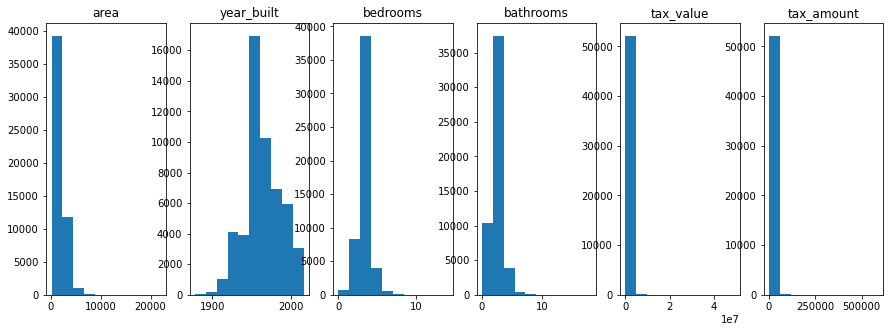

In [24]:
plt.figure(figsize=(15, 5))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Aways
- x axis range is showing with no values meaning they are skewed
- tax_value has sever skew since its x-axis got to 1e7 
- area has skew

### Plot Box Plots

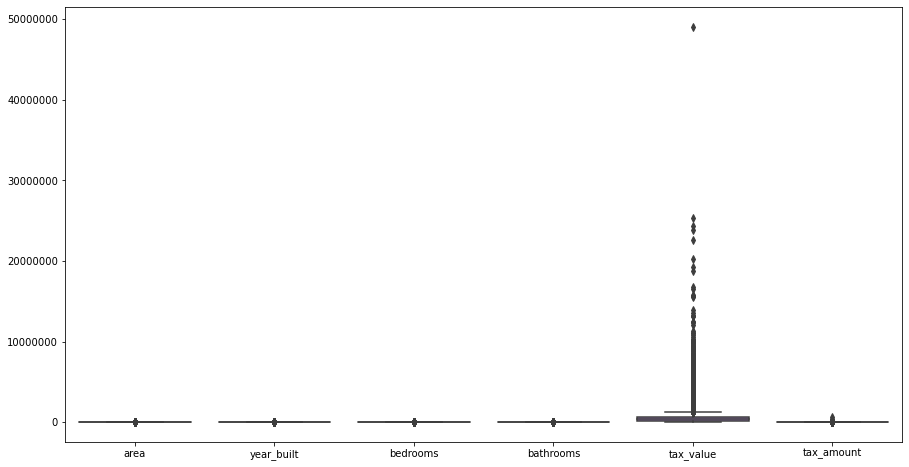

In [25]:
# plot box plots for columns except fips
plt.figure(figsize=(15,8))
plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))
plt.show()

### Take Aways
- tax_value has a severe skew making the other columsn unreadable

### Visualize Columns with Larger Box Plots

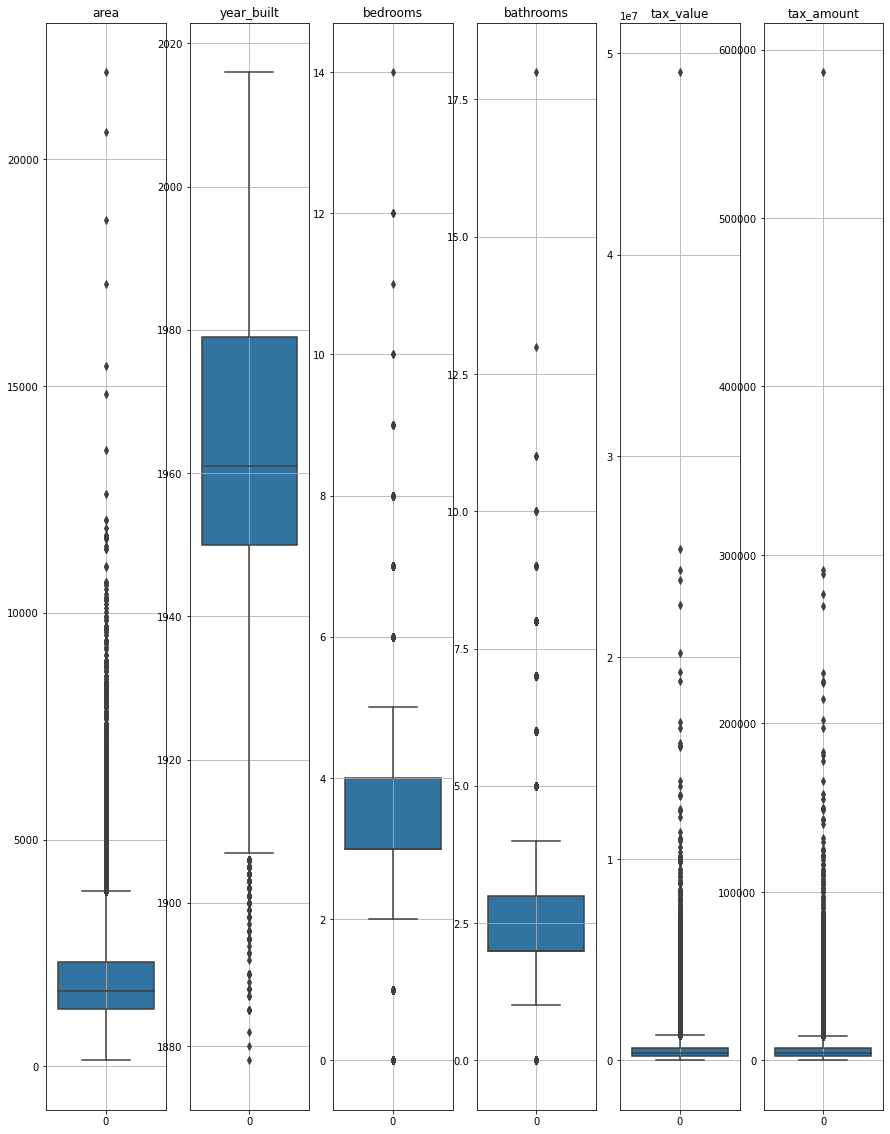

In [26]:
plt.figure(figsize=(15, 20))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Aways
- Lager Plot Boxesshow many outliers with a huge skew for tax_value

# <font color = 'red'>Prep Data (Tidy, Wrangle, Split)

## Tidy Data
### Remove Outliers

### Create List of columns to remove outliers from

In [27]:
cols_list = df.drop(columns='fips')
cols_list.head()

,area,year_built,bedrooms,bathrooms,tax_value,tax_amount
0,3100,1998,4,3,1023282,11013
1,1465,1967,2,1,464000,5672
2,1243,1962,3,2,564778,6488
3,2376,1970,4,3,145143,1777
4,2962,1950,4,3,773303,9516


### Check Shape and Row Count

In [28]:
df.shape

(52315, 7)

### Find quartile points for upper / lower bounds and remove outliers

In [29]:
 for col in cols_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + 2 * iqr   # get upper bound
        lower_bound = q1 - 2 * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

### Check shape and confirmed lost around 5K records

In [30]:
df.shape

(46953, 7)

### Display Box Plots to visualize new ranges

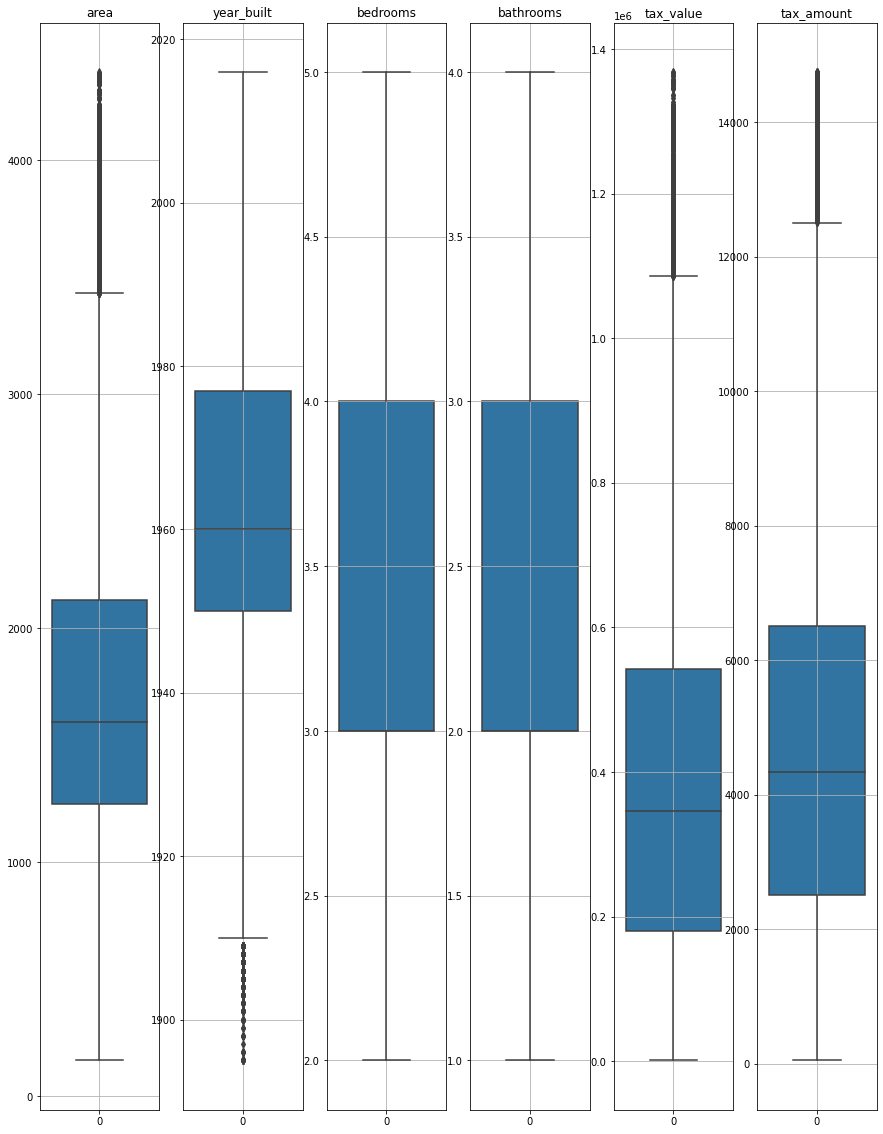

In [31]:
plt.figure(figsize=(15, 20))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Away:
- Box Plot outliers are more visual and boxes are clear
### Display historgrams to visualize distributions

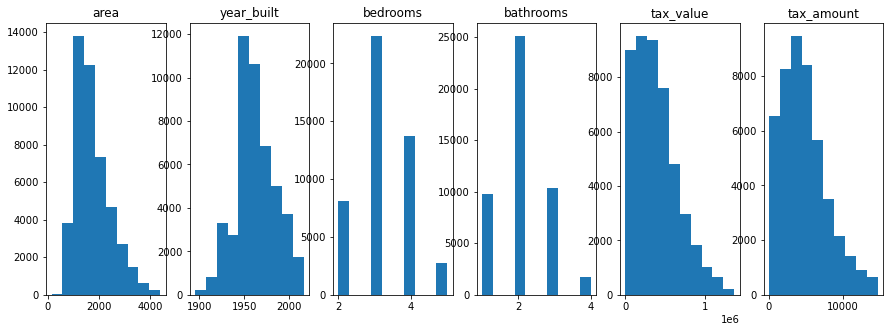

In [32]:
plt.figure(figsize=(15, 5))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Away:
- Distribution looks good, no more blanks along the x-axis
- End with 47.5K records

## Univariate Analysis

### Closer look at columns with histograph

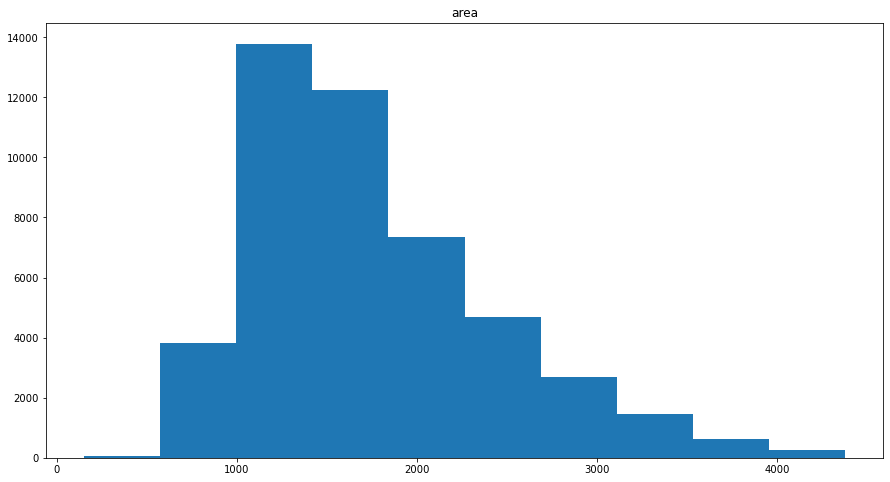

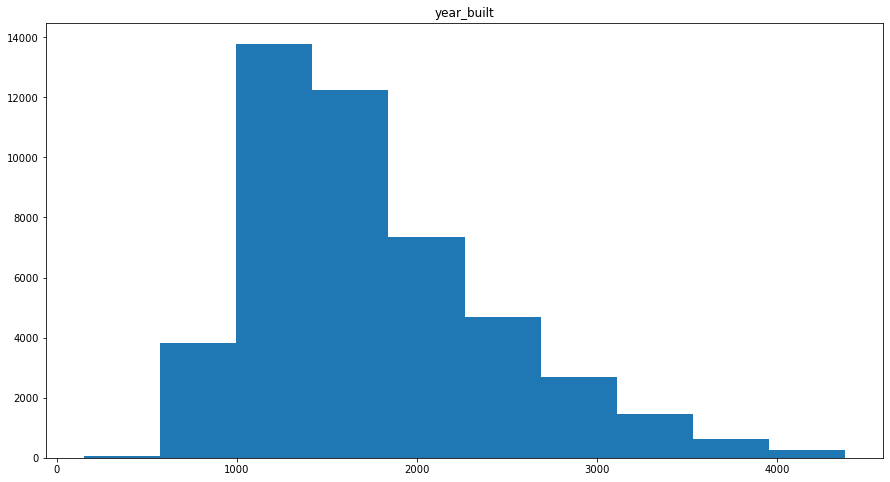

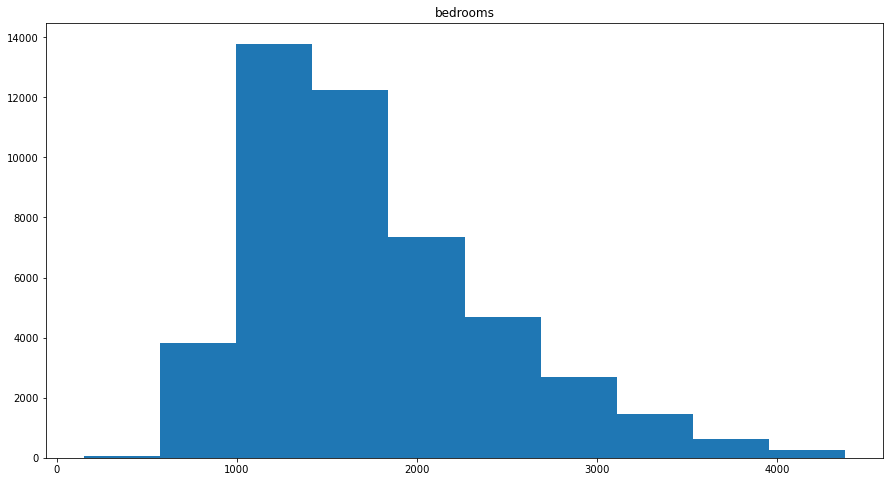

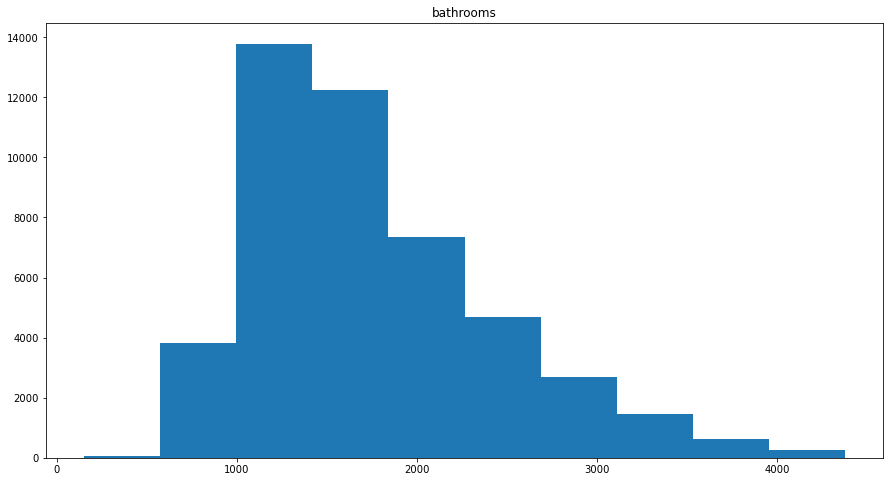

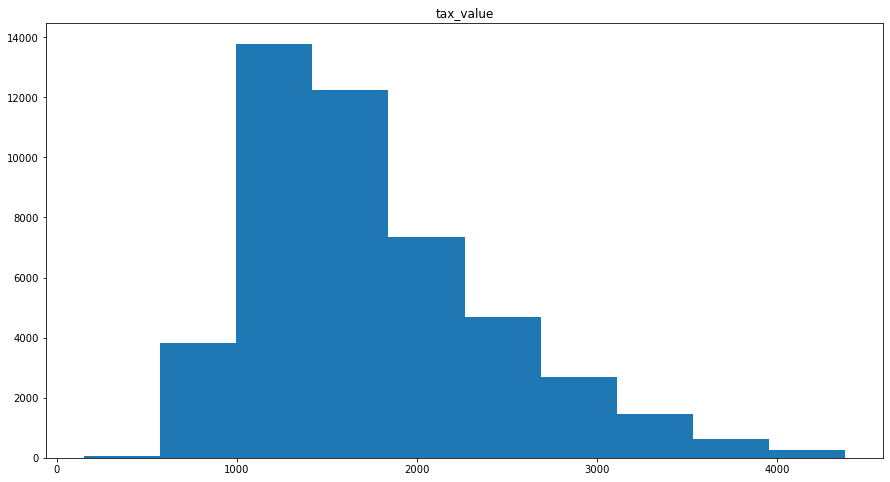

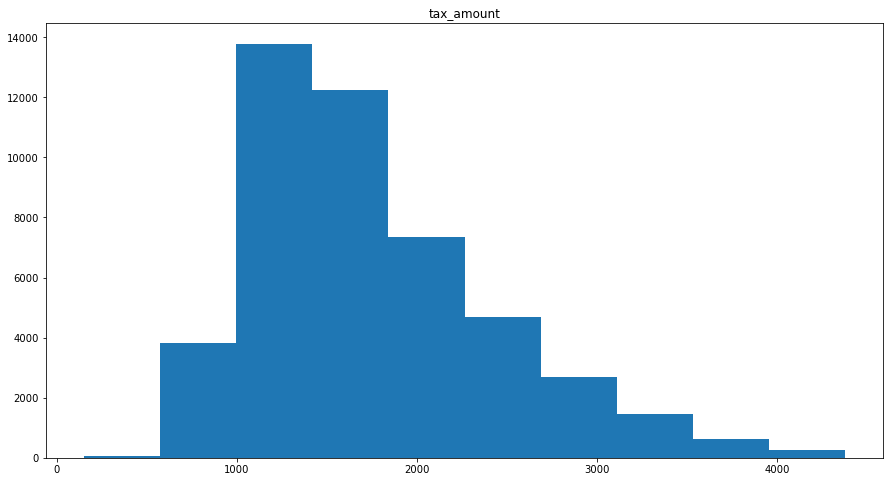

In [33]:
for col in cols_list:
    plt.figure(figsize=(15,8))
    plt.hist(df.area)
    plt.title(col)


In [34]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,area,year_built,bedrooms,bathrooms,tax_value,fips,tax_amount
count,46953,46953,46953,46953,46953,46953,46953
mean,1753.06,1962.69,3.23666,2.08611,390732,6049.32,4828.97
std,676.393,22.0276,0.802458,0.752047,266153,21.2818,3032.1
min,152,1895,2,1,1000,6037,49
25%,1249,1950,3,2,179374,6037,2502
50%,1598,1960,3,2,345673,6037,4339
75%,2122,1977,4,3,542000,6059,6505
max,4378,2016,5,4,1.36813e+06,6111,14749


In [35]:
df.bedrooms.value_counts()

3    22375
4    13702
2     8114
5     2762
Name: bedrooms, dtype: int64

In [36]:
df.bathrooms.value_counts()

2    25117
3    10406
1     9741
4     1689
Name: bathrooms, dtype: int64

In [37]:
df.fips.value_counts()

6037    30291
6059    12591
6111     4071
Name: fips, dtype: int64

## Data Context
- 47.5K records
- lowest tax_value is 1K
- highest tax_value is 1.37M
- mean tax_value is about 400K
- bedroom counts: 2,3,4,5
- bathroom counts: 1,2,3,4
- fips (county): 6037 (Los Angeles County),6059 (Orange County) , 6111 (Ventura County)

## Split Data

In [38]:
 # train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [39]:
train.shape, validate.shape, test.shape

((26293, 7), (11269, 7), (9391, 7))

# <font color ='red'> Exploration and Pre-Processing

## Explore Train Data

### What are the questions:
- What are the transactions are in 2017?
    - Started with 52.5K houses, removed 5K for outliers/nulls, 47.5K houses remaining
- What states and counties are the properties located in?
    - California,. Counties: Los Angeles, Ventura, Orange
- What is the tax rate per county? (might have to combine columns to calcualate)
    - Los Angele County Tax Rate: 1.42%
    - Orange County Tax Rate: 1.21%
    - Vetura County Tax Rate: 1.18%
- What is the distribution of tax_value for each county?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

### What is the tax rate per county?

In [40]:
((df[df.fips==6037].tax_amount) / (df[df.fips==6037].tax_value)).mean()

0.014237860260653728

In [41]:
((df[df.fips==6059].tax_amount) / (df[df.fips==6059].tax_value)).mean()

0.012130153795080171

In [42]:
((df[df.fips==6111].tax_amount) / (df[df.fips==6111].tax_value)).mean()

0.01178973177535086

## Multivariate Analysis

### What is the distribution of tax_value across counties
### Show Average Tax Amounts across Counties

<AxesSubplot:xlabel='fips', ylabel='tax_amount'>

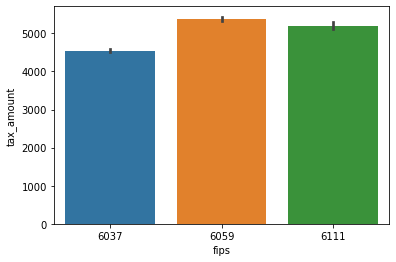

In [43]:
sns.barplot(x=df.fips, y=df.tax_amount)

### Notes:
- Tax Amounts across counties don't have significant difference
### Shows Average Tax Value Across Counties

<AxesSubplot:xlabel='fips', ylabel='tax_value'>

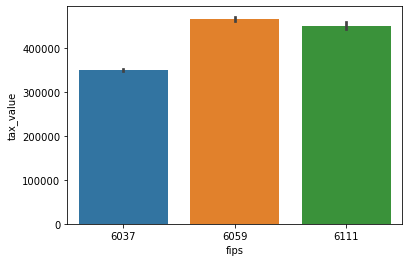

In [44]:
sns.barplot(x=df.fips, y=df.tax_value)

### Notes:
- No significant differnce of tax values between counties however 6037 does drop
### Use Pair Plot to find correlation

In [45]:
#sns.pairplot(train)

### Notes:
- Nothing siginficant to show
### Show Heatmap to find correlation between columns

<AxesSubplot:>

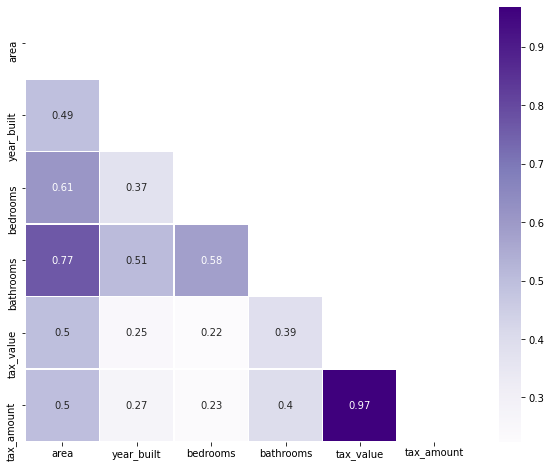

In [62]:
corr_table = train.drop(columns=['fips']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_table, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(corr_table))

### Notes:
- tax_value:area = .50
- tax_value:bathrooms = .39
- tax_value:year_built = .25
- tax_value:bedrooms = .22
- area:bathrooms = .77
- area:bedrooms = .61
- area:year_built = .49
- bathroom:bedrooms = .58
- bathroom:year_built = .51
### Largest Correlations to Value is Area. Area to Bathrooms and Bedrooms.

### Show correlation between year_built and area with tax_value

<Figure size 720x720 with 0 Axes>

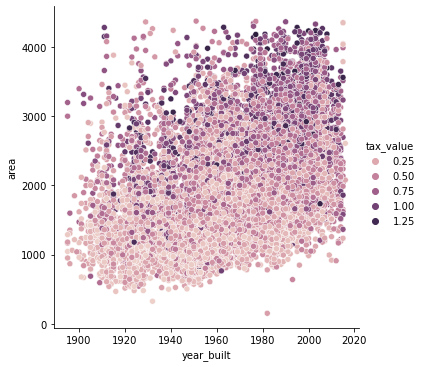

In [48]:
# Shows that value increases with area & year_built
plt.figure(figsize=(10,10))
sns.relplot(x='year_built', y='area', data=train,  hue='tax_value', kind='scatter')

### Notes:
- Show tax_value increases with area increase but year_built has little impact

### Show correlation between tax_value and area with bathrooms

<Figure size 720x720 with 0 Axes>

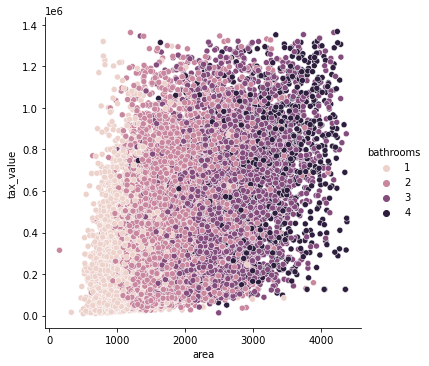

In [49]:
#shows that increasd area tends to have increases bathrooms. Slight correlation to increased value.
plt.figure(figsize=(10,10))
sns.relplot(x='area', y='tax_value', data=train, hue='bathrooms', kind='scatter')

### Notes:
- Shows that increased area has correlatioin with increased  bathroms but little impact to price

### Show correlation between area and tax_value with bedrooms

<Figure size 720x720 with 0 Axes>

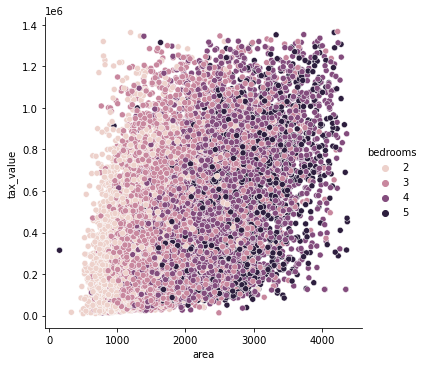

In [50]:
# Shows that bedrooms does not associate to value. Mostly to area.
plt.figure(figsize=(10,10))
sns.relplot(x='area', y='tax_value', data=train, hue='bedrooms', kind='scatter')

### Notes:
- Show that bedrooms have slight correlatoin to area but not as much as bathroom. And little impact to value

### Show correlation between year_built and tax_value with bathrooms

<Figure size 720x720 with 0 Axes>

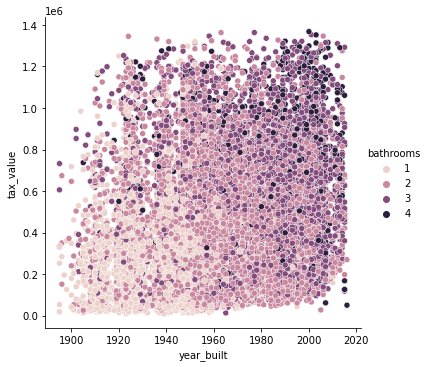

In [51]:
plt.figure(figsize=(10,10))
sns.relplot(x='year_built', y='tax_value', data=train, hue='bathrooms', kind='scatter')

### Notes:
- Show later years have more bathrooms which also have higher tax_value

### Show correlation between year_built and tax_value with bedrooms

<Figure size 720x1440 with 0 Axes>

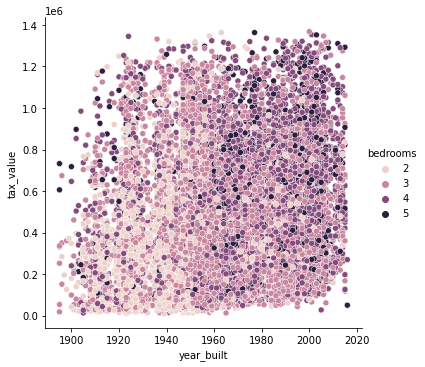

In [52]:
# Shows that later years have more bedrooms but seem to impact value
plt.figure(figsize=(10,20))
sns.relplot(x='year_built', y='tax_value', data=train, hue='bedrooms', kind='scatter')
plt.show()

### Notes:
- Slight correlation with inceasd bedrooms and new homes which increases value. Most likely because increased bedrooms means increased area.

### Show correlation between year_built and value with area

<Figure size 720x1440 with 0 Axes>

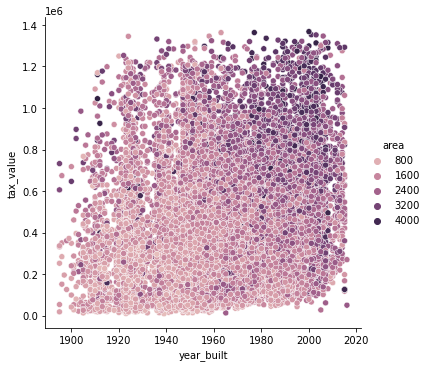

In [53]:
# Shows increased area has  year increased and more high areas have high value
plt.figure(figsize=(10,20))
sns.relplot(x='year_built', y='tax_value', data=train, hue='area', kind='scatter')
plt.show()

### Notes:
- Shows increased area are newer homes and have high value

### Show correlation between year_built and value with fips

<Figure size 1080x360 with 0 Axes>

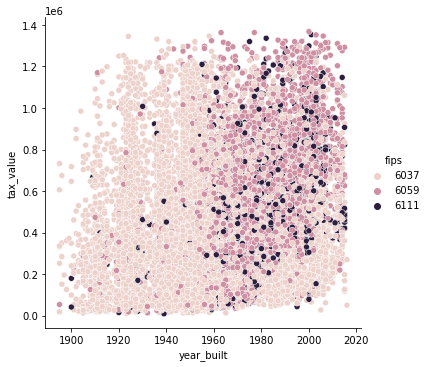

In [54]:
# shows that 6037 has majority of properties, 6059 has more high value properties
plt.figure(figsize=(15,5))
sns.relplot(x='year_built', y='tax_value', data=train, hue='fips', kind='scatter')
plt.show()

### Notes:
- shows that 6037 has majority of properties
- show that 6059 abd 6111 has newer homes

### Show correlation between area and value with fips

<Figure size 1080x360 with 0 Axes>

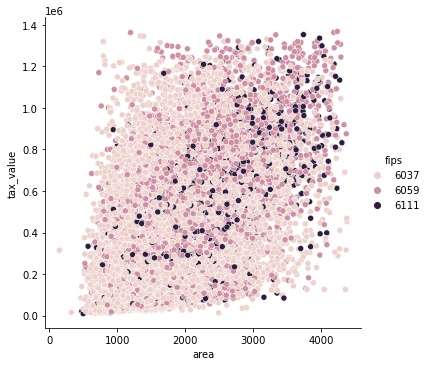

In [63]:
# compare area vs value by fips
plt.figure(figsize=(15,5))
sns.relplot(x='area', y='tax_value', data=train, hue='fips', kind='scatter')
plt.show()

### Notes:
- Shows area and value correlate across fips

### Show Bar Plot for value vs area cat by fips

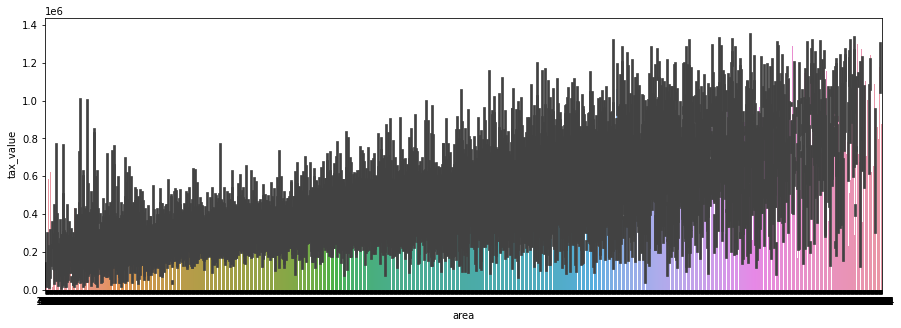

In [64]:
# Bar plot for value vs area categoriezed by fips.
plt.figure(figsize=(15,5))
sns.barplot(data=train, y='tax_value', x='area')
plt.show()

### Note:
- Show nothing new. value increases with area.

### Show Strip Plot

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

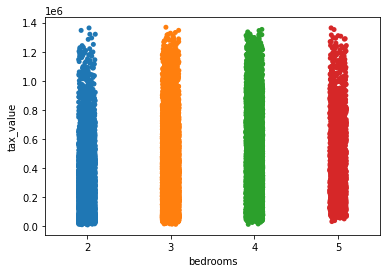

In [57]:
sns.stripplot(x='bedrooms', y='tax_value', data=train)

### Note:
- Stip Plot shows nothging readable

## Summarize Exploration
- 

## Pre-Processing (Prep Data for Modeling)

### Drop Unusable and Unneeded Columns for Modeling

In [ ]:
df.head()

### Create y_train and X_train sets

## Summarize Exploration & Pre-Precessing

# <font color = 'red'>Modeling

## Select Evaluation Metric

## Create & Evaluate Baseline

## Develop Models 

### Create Model 1 - Decision Tree 

### Create Model 2 - Random Forest

### Create Model 3 - K-Nearest Neighbor

## Evaluate on Train 

## Evaluate on Validate

## Evaluate on Test

# <font color ='red'>Final Report

## Conclusion Summary

## Conclusion Recommendations

## Conclusion Next steps

## Live Presentation

- intro (live)
- audience & setting  (live)
- content (live)
- Verbal Conclusion (findings, next steps, recommendations)  (live) 
- time (live) 

## Deliver Predictions
- Deliver predictions (.csv) 